# 🐧 MLPClassifier Example: Predicting Penguin Species

This notebook demonstrates how to apply **scikit-learn's MLPClassifier** — a simple neural network — to classify penguins into species using the **Palmer Penguins dataset**.

### Learning Objectives
- Load and preprocess real-world categorical and numerical data
- Train a Multi-Layer Perceptron (MLP) model
- Evaluate using accuracy, precision, recall, F1-score, confusion matrix, and ROC curve

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

plt.style.use('seaborn-v0_8-colorblind')

### 1️⃣ Load the Palmer Penguins Dataset

In [2]:
import seaborn as sns

df= sns.load_dataset("penguins")
df.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


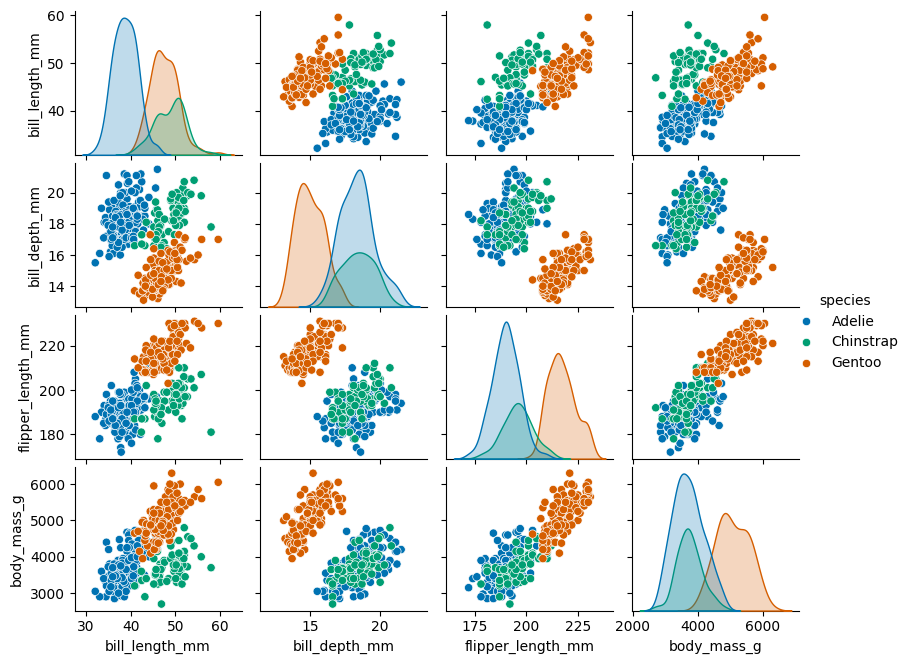

In [3]:
pairplot_figure = sns.pairplot(df, hue="species")
pairplot_figure.fig.set_size_inches(9, 6.5)

### Anther way to load the dataset

In [4]:
# url = 'https://raw.githubusercontent.com/allisonhorst/palmerpenguins/master/inst/extdata/penguins.csv'
# df = pd.read_csv(url)
# print('Dataset shape:', df.shape)
# df.head()

### 2️⃣ Data Cleaning and Preprocessing

In [5]:
df = df.dropna()
features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g', 'sex', 'island']
target = 'species'
X = df[features]
y = df[target]
print('Number of samples after cleaning:', len(df))
df.head()

Number of samples after cleaning: 333


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


### 3️⃣ Encode Categorical Features and Target

In [6]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)
categorical_cols = ['sex', 'island']
numeric_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_cols),
    ('num', StandardScaler(), numeric_cols)
])

### 4️⃣ Split Data into Training and Test Sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.25, random_state=42, stratify=None) #stratify=y_encoded or stratify=df["island"]
print('Training samples:', len(X_train), '| Test samples:', len(X_test))

Training samples: 249 | Test samples: 84


### 5️⃣ Build and Train the MLP Classifier

In [8]:
mlp = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MLPClassifier(hidden_layer_sizes=(10), activation='relu', solver='adam', max_iter=1000, random_state=42)) #Try two hidden layers MLPClassifier(hidden_layer_sizes=(10,5)
])

mlp.fit(X_train, y_train)
print('Training completed!')

Training completed!


### 6️⃣ Evaluate Model Performance

In [9]:
y_pred = mlp.predict(X_test)
y_score = mlp.predict_proba(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average='macro')
rec = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f'Accuracy:  {acc:.3f}')
print(f'Precision: {prec:.3f}')
print(f'Recall:    {rec:.3f}')
print(f'F1-score:  {f1:.3f}')

Accuracy:  0.988
Precision: 0.992
Recall:    0.978
F1-score:  0.984


In [10]:
# Per class metrics

print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

      Adelie       0.98      1.00      0.99        40
   Chinstrap       1.00      0.93      0.97        15
      Gentoo       1.00      1.00      1.00        29

    accuracy                           0.99        84
   macro avg       0.99      0.98      0.98        84
weighted avg       0.99      0.99      0.99        84



### 7️⃣ Confusion Matrix Visualization

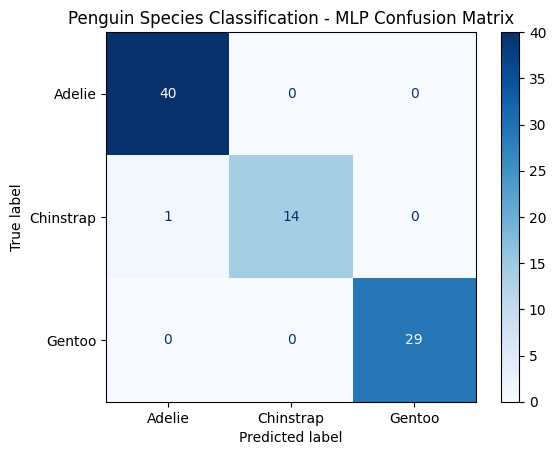

In [11]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Penguin Species Classification - MLP Confusion Matrix')
plt.show()

Adelie: 1.000
Chinstrap: 0.933
Gentoo: 1.000


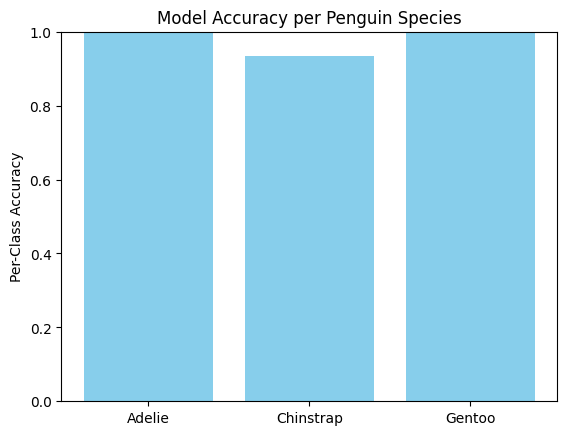

In [12]:
# Calculate per-class accuracy (diagonal / row sum)
class_accuracy = cm.diagonal() / cm.sum(axis=1)

# Print accuracy per class
for label, acc in zip(le.classes_, class_accuracy):
    print(f"{label}: {acc:.3f}")

# Optional: visualize as bar chart
plt.bar(le.classes_, class_accuracy, color='skyblue')
plt.ylabel("Per-Class Accuracy")
plt.ylim(0, 1)
plt.title("Model Accuracy per Penguin Species")
plt.show()

### 8️⃣ ROC Curves for Multi-class Classification

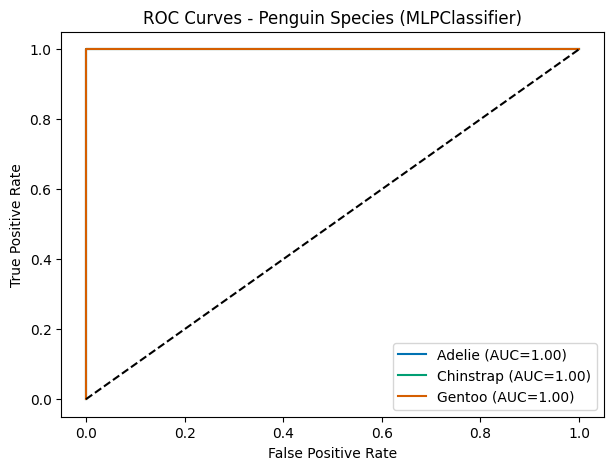

In [13]:
n_classes = len(le.classes_)
fpr, tpr, roc_auc = {}, {}, {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7,5))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{le.classes_[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves - Penguin Species (MLPClassifier)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## ✅ Summary
- **Dataset:** Palmer Penguins (species classification)
- **Preprocessing:** One-hot encoding + standard scaling
- **Model:** Multi-Layer Perceptron (two hidden layers)

**Key Takeaways:**
- Neural networks can handle both numerical and categorical features.
- Scaling is essential for convergence.
- The MLP achieved strong performance across all penguin species.